# Linear Logistic Regression in NumPy

Fast logistic regression in NumPy with Conjugate Gradients from the SciPy optimize module.

In [752]:
import numpy as np
import scipy.optimize as spopt

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)

Some basic numerical functions, `cap_zero` takes values very close or equal to zero and makes them "tiny" non-zero values.  `softmax` computes the softmax along the last axis of a multi-axis array and `log_softmax` compute the natural log of the softmax along the last axis, in a way that is slightly faster and more numerically stable than computing the direct log of `softmax`.

In [753]:
def cap_zero(x, value=None):
    '''Return a copy of `x` where all values are capped at `value`,
    i.e., no values in the array are less than `value`.  If `value`
    is `None` (default) then the `np.finfo` `tiny` value is used
    for the `dtype` of `x`.
    '''
    if value is None:
        value = np.finfo(x.dtype).tiny
    x = x.copy()
    x[x < value] = value
    return x

def softmax(x):
    '''Compute the softmax of `x` along the last axis.'''
    mx = np.max((np.max(x), 0.0))
    terms = cap_zero(np.exp(x - mx))
    denom = np.sum(terms, axis=-1)[..., None]
    return terms / denom

def log_softmax(x):
    '''Compute the natural log of the softmax of `x` along the last axis.'''
    mx = np.max((np.max(x), 0.0))                                                                   
    xmx = x - mx                                                                                    

    terms = cap_zero(np.exp(xmx))
    denom = np.sum(terms, axis=-1)[..., None]
    log_denom = np.log(cap_zero(denom))
                                                                                                             
    return xmx - log_denom

And now for the logistic regression implementation...

In [754]:
class LogisticRegression:
    '''Linear Logistic Regression.
    
    Inputs:
        x: np.array((..., ndim))
            The input features over which to perform a prediction.
            
    Outputs:
        logits: np.array((..., ncls))
            Predicted logit indicators for each class.  Higher values
            indicate a more confident prediction.  For predicted
            probabilities in (0,1), see the `.probs` method.
    '''
    def __init__(self, ndim, ncls):
        '''Construct a new Linear Logistic Regression classifier.
        
        Args:
            ndim: int
                The number of input dimensions / features.
            ncls: int
                The number of classes in a prediction.
        '''
        self.ndim, self.ncls = ndim, ncls

        weight_scale = np.sqrt(3.0) / ndim
        self.weights = np.random.uniform(
            -weight_scale, weight_scale,
            size=(self.ndim+1, self.ncls))
        
    @property
    def parameters(self):
        '''Return a single flat NumPy array containing all of the
        parameters for this model.  Used for optimization with
        `scipy.optimize`.
        '''
        return self.weights.ravel()
        
    def __call__(self, x):
        '''Return predicted logits.'''
        assert x.ndim >= 2
        return x @ (self.weights[:-1]) + self.weights[-1]
    
    def probs(self, x):
        '''Return the predicted class membership probabilities.'''
        return softmax(self(x))
    
    def labels(self, x):
        '''Return the predicted class labels as integers.'''
        return np.argmax(self(x), axis=-1)
    
    def loss(self, x, g):
        '''Return the log loss, i.e., cross-entropy loss.'''
        likes = log_softmax(self(x))
        
        # pointwise multiplication of log likelihoods times target indicator
        # variables can be computed by simply selecting along the last axis
        likes_g = np.take_along_axis(likes, g[..., None], axis=-1)
        
        return -np.mean(likes_g)
    
    def grad(self, x, g):
        '''Return the gradient matrix using cross-entropy loss.
        This should be flattened for use with `scipy.optimize`.'''
        probs = softmax(self(x))

        delta = probs.reshape((-1, probs.shape[-1]))
        delta[range(delta.shape[0]), g.flat] -= 1.0
        
        x1 = np.concatenate((x, np.ones_like(x[..., 0])[..., None]), axis=-1)
        grad = x1.T.reshape((x1.shape[-1], -1)) @ delta
        
        return grad
    
    def train(self, x, g, precision=1.0e-6, method='cg', **options):
        '''Train this logistic regression model using `scipy.optimize.minimize`.
        The model is trained in place.
        
        Args:
            x: np.array(..., ndim)
                The training input data.
            g: np.array(...)
                Integer target class labels.
            precision: float
                The precision after which training will terminate.
            method: str
                The training method used by `scipy.optimize`.
                Defaults to `cg` conjugate gradients.
            **options:
                Additonal arguments to pass to `scipy.optimize.minimize`.
                
        Returns:
            dict
                A dictionary of result information returned by the
                `scipy.optimize.minimize` function.
        '''
        def loss_func(parameters):
            '''Set parameters on self and computes the log loss.'''
            self.parameters[...] = parameters
            return self.loss(x, g)
        
        def grad_func(parameters):
            '''Set parameters on self and compute the flattened gradient.'''
            self.parameters[...] = parameters
            return self.grad(x, g).ravel()
        
        # deligate minimization to scipy
        return spopt.minimize(
            fun=loss_func, method=method, x0=self.parameters,
            tol=precision, jac=grad_func, options=options)

A simple test with multi-axis arrays.  The last axis is for features, any earlier axes are additional observations, e.g., `number_of_sentences` x `number_of_words` x `word_embedding_size`.

In [755]:
inputs = np.random.random((4, 10, 32))
targets = np.array(inputs.sum(-1) < 0.5, dtype=np.int)

lr_model = LogisticRegression(32, 2)
opt_result = lr_model.train(inputs, targets)
print(opt_result)

logits = lr_model(inputs)
probs = lr_model.probs(inputs)
labels = lr_model.labels(inputs)
loss = lr_model.loss(inputs, targets)
grad = lr_model.grad(inputs, targets)

print('logits:', logits.shape)
print('probs:', probs.shape)
print('labels:', labels.shape)
print('loss:', loss)

     fun: 1.982685200704419e-08
     jac: array([-4.8584e-07,  4.8584e-07, -3.6477e-07,  3.6477e-07, -3.0036e-07,
        3.0036e-07, -4.4638e-07,  4.4638e-07, -3.5664e-07,  3.5664e-07,
       -3.9467e-07,  3.9467e-07, -3.9999e-07,  3.9999e-07, -3.7886e-07,
        3.7886e-07, -3.4354e-07,  3.4354e-07, -4.5940e-07,  4.5940e-07,
       -4.6351e-07,  4.6351e-07, -3.3886e-07,  3.3886e-07, -3.1328e-07,
        3.1328e-07, -4.3147e-07,  4.3147e-07, -3.1553e-07,  3.1553e-07,
       -3.9868e-07,  3.9868e-07, -2.9673e-07,  2.9673e-07, -3.4675e-07,
        3.4675e-07, -3.3477e-07,  3.3477e-07, -4.0128e-07,  4.0128e-07,
       -4.0307e-07,  4.0307e-07, -4.0708e-07,  4.0708e-07, -3.4635e-07,
        3.4635e-07, -4.6475e-07,  4.6475e-07, -3.1067e-07,  3.1067e-07,
       -3.9081e-07,  3.9081e-07, -4.5745e-07,  4.5745e-07, -4.3713e-07,
        4.3713e-07, -3.8704e-07,  3.8704e-07, -2.9153e-07,  2.9153e-07,
       -3.2711e-07,  3.2711e-07, -2.8313e-07,  2.8313e-07, -7.9307e-07,
        7.9307e-07])
 

Conjugate gradients documentation below.  CG should be able to solve in number of inputs iterations (plus a few for numerical precision).  Note that there may be multiple function and gradient evaluations for each iteration, each iteration corresponds to a search direction but still have to optimize along each direction.

In [756]:
#spopt.fmin_cg?

A 1D example with three classes, shows that it works!!

     fun: 0.08114801317457654
     jac: array([-0.4078,  1.1458, -0.738 ,  0.8961, -0.226 , -0.6701])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 44
     nit: 10
    njev: 44
  status: 1
 success: False
       x: array([-8.6617,  2.1363,  9.8976, -1.5958,  2.7377, -2.1852])
c1:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
c2:
[1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
c3:
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


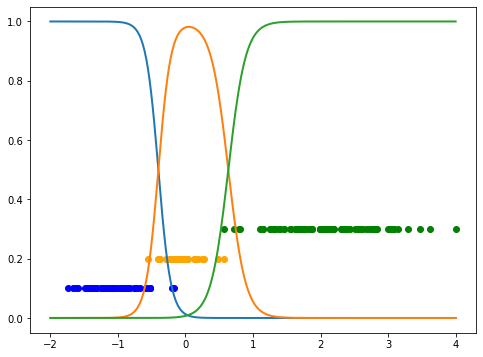

In [757]:
c1 = np.random.normal(loc=-1.0, scale=0.3, size=(60, 1))
c2 = np.random.normal(loc=0.0, scale=0.3, size=(30, 1))
c3 = np.random.normal(loc=2.0, scale=0.7, size=(90, 1))
inputs = np.concatenate((c1, c2, c3), axis=0)
targets = np.array([0,]*c1.size + [1,]*c2.size + [2,]*c3.size)

model = LogisticRegression(1, 3)
opt_result = model.train(inputs, targets, method='cg', maxiter=10)
print(opt_result)
                                                                                                    
c1_probs = model.probs(c1)                                                                       
c2_probs = model.probs(c2)                                                                       
c3_probs = model.probs(c3)                                                                       
                                                                                                    
print("c1:")                                                                                    
print(model.labels(c1))                                                                          
print("c2:")                                                                                    
print(model.labels(c2))                                                                          
print("c3:")                                                                                    
print(model.labels(c3))                                                                          
                                                                                                    
x = np.linspace(-2.0, 4.0, 500)[:, None]
x_probs = model.probs(x)                                                                         
                                                                                                    
plt.plot(x, x_probs, linewidth=2)
plt.scatter(c1, np.zeros_like(c1) + 0.1, color='blue');
plt.scatter(c2, np.zeros_like(c2) + 0.2, color='orange');
plt.scatter(c3, np.zeros_like(c3) + 0.3, color='green');

In [758]:
# covariance matrix for each training class
cov = [[1, -0.8],
       [-0.8, 1]]

# red data
red = np.random.multivariate_normal((-1, -1), cov, 500)

# green data
green = np.random.multivariate_normal((0, 0), cov, 300)

# blue data
blue = np.random.multivariate_normal((1, 1), cov, 400)

inputs = np.vstack((red, green, blue))
targets = np.array(([0,]*red.shape[0] + [1,]*green.shape[0] + [2,]*blue.shape[0]))

# min and max training values                                                                   
mn = np.min(inputs, axis=0)
mx = np.max(inputs, axis=0)

# train model
model2 = LogisticRegression(2, 3)
opt_result = model2.train(inputs, targets)

print('optimization result:')
print(opt_result)

# find class labels
red_labels = model2.labels(red)
green_labels = model2.labels(green)                                                                 
blue_labels = model2.labels(blue)                                                                   
                                                                                                    
print("\nred labels:")
print(red_labels)                                                                                 
print("\ngreen labels:")
print(green_labels)                                                                               
print("\nblue labels:")
print(blue_labels)

optimization result:
     fun: 0.14647015668052052
     jac: array([ 4.0107e-06, -1.8218e-05,  1.4208e-05,  2.1911e-07, -2.5380e-06,
        2.3189e-06, -1.0850e-05,  1.8926e-05, -8.0760e-06])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 525
     nit: 72
    njev: 513
  status: 2
 success: False
       x: array([-6.4646,  0.1673,  5.4143, -6.0637,  0.4505,  5.6816, -2.0971,
        3.9614, -1.1684])

red labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0

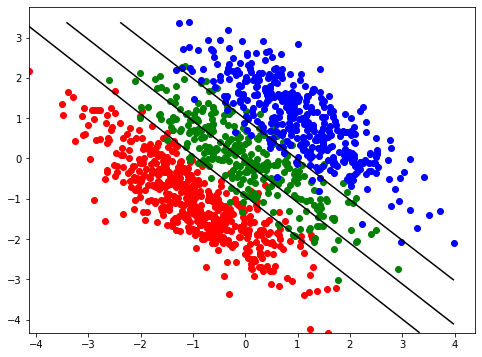

In [759]:
# first figure shows training data and class intersections
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# training data
ax.scatter(red[:,0],   red[:,1],   color='red')
ax.scatter(green[:,0], green[:,1], color='green')
ax.scatter(blue[:,0],  blue[:,1],  color='blue')

# generate grid over training data
sw = 0.02
sx = np.arange(mn[0], mx[0], sw)
sy = np.arange(mn[1], mx[1], sw)
x, y = np.meshgrid(sx, sy, copy=False)

# get probability densities and labels for values in grid
z = np.vstack((x.reshape((-1,)), y.reshape((-1,)))).T
probs = model2.probs(z)

# red, green, blue and max probability densities
redp = np.reshape(probs[:,0,None], x.shape)
greenp = np.reshape(probs[:,1,None], x.shape)
bluep = np.reshape(probs[:,2,None], x.shape)
maxp = np.reshape(np.max(probs, axis=1), x.shape)

# class intersections
diff_rg = redp   - greenp
diff_rb = redp   - bluep
diff_gb = greenp - bluep
ax.contour(x, y, diff_rg, colors="black", levels=(0,));
ax.contour(x, y, diff_rb, colors="black", levels=(0,));
ax.contour(x, y, diff_gb, colors="black", levels=(0,));

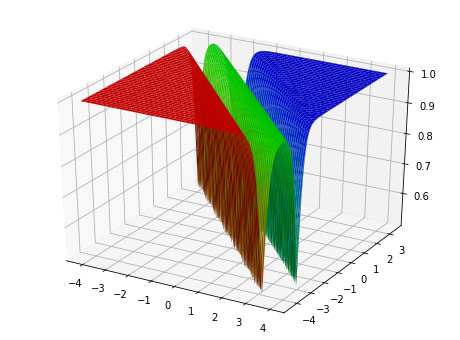

In [760]:
# second figure shows 3d plots of probability densities
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

# straight class colors for suface plots
color = np.reshape((redp, greenp, bluep), (3, x.shape[0], x.shape[1]))
color = color.swapaxes(1, 2).T

# flip colors to fade to white
zro = np.zeros_like(x)
color_flip = np.ones((3, x.shape[0], x.shape[1]))
color_flip -= (
    np.array((zro, redp, redp)) +
    np.array((greenp, zro, greenp)) +
    np.array((bluep, bluep, zro))
)
color_flip -= np.min(color_flip)
color_flip /= np.max(color_flip)
color_flip = color_flip.swapaxes(1, 2).T

# probability density surface
surf = ax.plot_surface(x, y, maxp, facecolors=color_flip,
                       linewidth=0.02, shade=True)

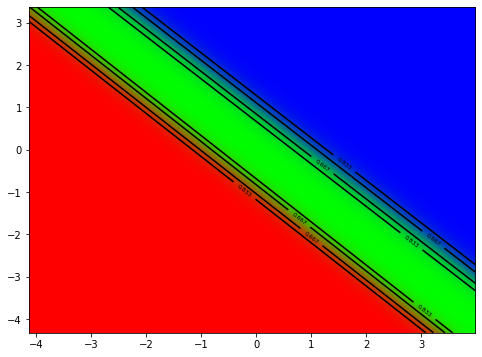

In [761]:
# third figure shows contours and color image of probability densities
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

#ax.pcolor(x, y, pMax)
ax.imshow(color_flip, origin='lower',
          extent=(mn[0], mx[0], mn[1], mx[1]), aspect='auto')

# contours
nlevel = 4
cs = ax.contour(x, y, maxp, colors='black',
                levels=np.linspace(np.min(maxp), np.max(maxp), nlevel));
cs.clabel(fontsize=6);

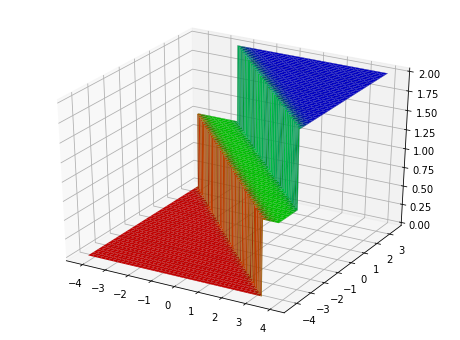

In [762]:
# fourth figure
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')

labels = model2.labels(z)
lmax = np.reshape(labels, x.shape)

surf = ax.plot_surface(x, y, lmax, facecolors=color_flip, linewidth=0.02)
surf.set_edgecolor('black')

Just some tinkering around with NumPy indexing... I'll delete this once I'm sure it's how I want it above.

In [671]:
a = np.random.random((10, 12))
b = np.random.random(10*12)

a.flat[...] = b

a, b

(array([[0.1846, 0.9708, 0.4211, 0.825 , 0.9875, 0.7978, 0.1956, 0.6631,
         0.9146, 0.3457, 0.4848, 0.4582],
        [0.1037, 0.2699, 0.0875, 0.2412, 0.1034, 0.144 , 0.6318, 0.5515,
         0.862 , 0.6188, 0.4889, 0.2868],
        [0.5789, 0.0224, 0.4229, 0.7821, 0.5187, 0.2616, 0.5835, 0.3473,
         0.8611, 0.8676, 0.0074, 0.036 ],
        [0.5805, 0.1344, 0.3883, 0.0465, 0.831 , 0.9733, 0.079 , 0.1516,
         0.7036, 0.8003, 0.4568, 0.4676],
        [0.0751, 0.7359, 0.5792, 0.5629, 0.5766, 0.3621, 0.3967, 0.4253,
         0.065 , 0.8921, 0.8955, 0.0763],
        [0.2761, 0.9253, 0.2707, 0.1605, 0.6149, 0.8457, 0.346 , 0.3364,
         0.5739, 0.2702, 0.4598, 0.1437],
        [0.4506, 0.7329, 0.8367, 0.2169, 0.0999, 0.4355, 0.1921, 0.7951,
         0.8383, 0.2729, 0.4067, 0.9361],
        [0.695 , 0.7208, 0.4846, 0.5791, 0.7497, 0.5233, 0.9498, 0.2124,
         0.2884, 0.4668, 0.6786, 0.1167],
        [0.3857, 0.5314, 0.492 , 0.6111, 0.2545, 0.2853, 0.9598, 0.2918,
       

In [672]:
a = np.random.random((2, 4, 3))
g = np.array([0, 0, 2, 1])
a.shape, a[..., range(a.shape[1]), g].shape
a, a[..., range(a.shape[-2]), g]

(array([[[0.3979, 0.5341, 0.6299],
         [0.5104, 0.9591, 0.3595],
         [0.9625, 0.7018, 0.4817],
         [0.6365, 0.2419, 0.3991]],
 
        [[0.9764, 0.9687, 0.0133],
         [0.6826, 0.2622, 0.8289],
         [0.8461, 0.8879, 0.1021],
         [0.4512, 0.6133, 0.1701]]]), array([[0.3979, 0.5104, 0.4817, 0.2419],
        [0.9764, 0.6826, 0.1021, 0.6133]]))

In [673]:
a = np.random.random((4, 3))
g = np.array([0, 0, 2, 1])
print(g, g.shape)
print(a, a.shape)
print(a[range(a.shape[0]), g], a[range(a.shape[0]), g].shape)

[0 0 2 1] (4,)
[[0.5907 0.9712 0.7316]
 [0.9847 0.8472 0.7952]
 [0.7452 0.7627 0.2069]
 [0.7476 0.1957 0.356 ]] (4, 3)
[0.5907 0.9847 0.2069 0.1957] (4,)


In [674]:
a = np.random.random((2, 4, 3))
g = np.array([[0, 0, 2, 1], [0, 0, 1, 2]])
rows, cols = np.indices(a.shape[:-1])
a, a[rows, cols, g]

(array([[[0.85  , 0.98  , 0.2472],
         [0.7431, 0.2071, 0.9998],
         [0.3195, 0.4172, 0.8113],
         [0.9737, 0.3856, 0.1007]],
 
        [[0.1833, 0.8996, 0.8587],
         [0.2815, 0.034 , 0.8259],
         [0.3396, 0.128 , 0.4552],
         [0.4689, 0.0279, 0.3313]]]), array([[0.85  , 0.7431, 0.8113, 0.3856],
        [0.1833, 0.2815, 0.128 , 0.3313]]))

In [675]:
a = np.random.random((4, 3))
g = np.array([0, 0, 2, 1])[:, None]
a, np.take_along_axis(a, g, axis=-1)

(array([[0.2515, 0.8006, 0.7263],
        [0.0817, 0.8576, 0.3051],
        [0.9586, 0.3135, 0.0092],
        [0.2276, 0.0753, 0.2066]]), array([[0.2515],
        [0.0817],
        [0.0092],
        [0.0753]]))

In [676]:
a = np.random.random((2, 4, 3))
g = np.array([[0, 0, 2, 1], [0, 0, 1, 2]])[..., None]
a, np.take_along_axis(a, g, axis=-1)

(array([[[0.315 , 0.1894, 0.8227],
         [0.8091, 0.7228, 0.6173],
         [0.3412, 0.1417, 0.0053],
         [0.8845, 0.6494, 0.0934]],
 
        [[0.2618, 0.6491, 0.8418],
         [0.2407, 0.5083, 0.0595],
         [0.9141, 0.3204, 0.4545],
         [0.7426, 0.6794, 0.9584]]]), array([[[0.315 ],
         [0.8091],
         [0.0053],
         [0.6494]],
 
        [[0.2618],
         [0.2407],
         [0.3204],
         [0.9584]]]))

In [677]:
a = np.random.random((2, 4, 3))
g = np.array([[0, 0, 2, 1], [0, 0, 1, 2]])

a, a.reshape((-1, a.shape[-1]))[range(2*4), g.flat].reshape(g.shape)

(array([[[0.9812, 0.8195, 0.6612],
         [0.1734, 0.0547, 0.4601],
         [0.252 , 0.7262, 0.0511],
         [0.8189, 0.6926, 0.525 ]],
 
        [[0.2158, 0.017 , 0.0699],
         [0.8535, 0.4828, 0.4626],
         [0.0182, 0.2211, 0.009 ],
         [0.4384, 0.9537, 0.3457]]]), array([[0.9812, 0.1734, 0.0511, 0.6926],
        [0.2158, 0.8535, 0.2211, 0.3457]]))

In [678]:
a = np.random.random((2, 4))
g = np.array([0, 1])

a, np.take_along_axis(a, g[:, None], axis=-1)
a, a[range(a.shape[0]), g]

(array([[0.3059, 0.1541, 0.6169, 0.4272],
        [0.006 , 0.6222, 0.2528, 0.2913]]), array([0.3059, 0.6222]))

In [679]:
(3,) * 4

(3, 3, 3, 3)